<table class="tfo-notebook-buttons" align="left">
  
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/ByteBrewer/waffle_hub/blob/Feature%2Fadd-colab-tutorial/tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  
</table>

# Waffle Hub Tutorial

## Install dependencies
- If you want to use CUDA install torch first.
    - https://pytorch.org/get-started/locally/

In [1]:
! pip install -r requirements.txt

## Prepare dataset

In [2]:
from waffle_utils.file import network, io

network.get_file_from_url(
    url="https://github.com/snuailab/waffle_utils/blob/main/mnist.zip?raw=true",
    out="./mnist.zip"
)

io.unzip(
    src="./mnist.zip",
    dst="extract",
    create_directory=True
)

In [3]:
from waffle_utils.dataset import Dataset
mnist_dataset = Dataset.from_coco(
    name="mnist_detection",
    coco_file="extract/exports/coco.json",
    coco_root_dir="extract/raw/"
)

In [4]:
mnist_dataset.split_train_val(0.8)
! tree datasets/mnist_detection/sets

datasets/mnist_detection/sets
├── train.json
└── val.json

0 directories, 2 files


In [5]:
export_dir = mnist_dataset.export("YOLO_DETECTION")
! tree -L 1 datasets/mnist_detection/exports/YOLO_DETECTION

datasets/mnist_detection/exports/YOLO_DETECTION
├── data.yaml
├── train
└── val

2 directories, 1 file


In [6]:
! cat datasets/mnist_detection/exports/YOLO_DETECTION/data.yaml

path: /home/lhj/ws/waffle_hub/datasets/mnist_detection/exports/YOLO_DETECTION
train: train
val: val
names:
    0: '1'
    1: '2'


## Search Available Backend Versions

In [7]:
from waffle_hub import get_available_backends

print(get_available_backends())

┌─────────────┬───────────┐
│ Backend     │ Version   │
├─────────────┼───────────┤
│ ultralytics │ 8.0.54    │
└─────────────┴───────────┘


/home/lhj/anaconda3/envs/play/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
! pip install ultralytics==8.0.54

## Create UltralyticsHub

In [9]:
from waffle_hub.hub import UltralyticsHub

hub = UltralyticsHub(
    name="digit_detector",
    task="object_detection",
    model_type="yolov8",
    model_size="n",
    classes=["1", "2"]
)
! tree hubs/digit_detector

hubs/digit_detector
└── configs
    └── model.yaml

1 directory, 1 file


In [10]:
! cat hubs/digit_detector/configs/model.yaml

name: digit_detector
backend: ultralytics
version: 8.0.54
task: object_detection
model_type: yolov8
model_size: n
classes:
-   supercategory: object
    name: '1'
-   supercategory: object
    name: '2'


### Train

In [11]:
model_dir = hub.train(
    dataset_path=export_dir,
    epochs=30,
    batch_size=16,
    image_size=320,
    letter_box=True
)

Ultralytics YOLOv8.0.54 🚀 Python-3.9.16 torch-1.13.1 CUDA:0 (NVIDIA GeForce RTX 4090, 24215MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/lhj/ws/waffle_hub/datasets/mnist_detection/exports/YOLO_DETECTION/data.yaml, epochs=30, patience=50, batch=16, imgsz=320, save=True, save_period=-1, cache=False, device=cuda:0, workers=2, project=hubs/digit_detector, name=artifacts, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=True, cos_lr=False, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True

In [12]:
! tree -L 1 hubs/digit_detector

hubs/digit_detector
├── artifacts
├── configs
├── metrics.csv
└── weights

3 directories, 1 file


In [13]:
! tree -L 1 hubs/digit_detector/weights

hubs/digit_detector/weights
├── best_ckpt.pt
└── last_ckpt.pt

0 directories, 2 files


### Inference

In [14]:
inference_dir = hub.inference(
    source="extract/raw/",
    batch_size=16,
    confidence_threshold=0.4,
    iou_thresold=0.7,
    draw=True
)

100%|██████████| 7/7 [00:00<00:00, 23.15it/s]


In [15]:
! tree -L 1 hubs/digit_detector/inferences

hubs/digit_detector/inferences
├── draw
└── results

2 directories, 0 files


In [16]:
! cat hubs/digit_detector/inferences/results/1.json

[
    {
        "bbox": [
            108.4107666015625,
            91.30363464355469,
            24.342849731445312,
            46.87542724609375
        ],
        "score": 0.565395712852478,
        "class_id": 0
    }
]

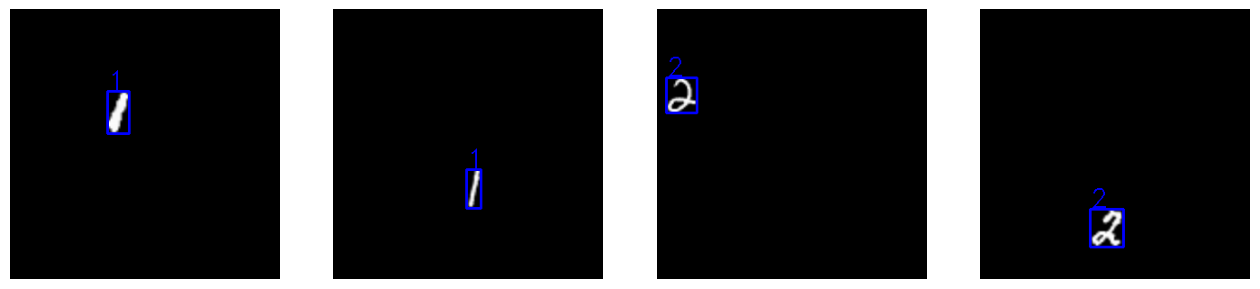

In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

figure = plt.figure(figsize=(16, 4))
axes = figure.subplots(1, 4)
axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[3].axis("off")

axes[0].imshow(cv2.imread("hubs/digit_detector/inferences/draw/1.png"))
axes[1].imshow(cv2.imread("hubs/digit_detector/inferences/draw/2.png"))
axes[2].imshow(cv2.imread("hubs/digit_detector/inferences/draw/92.png"))
axes[3].imshow(cv2.imread("hubs/digit_detector/inferences/draw/99.png"))

### Export to Onnx

In [18]:
export_path = hub.export()

/home/lhj/anaconda3/envs/play/lib/python3.9/site-packages/ultralytics/nn/modules.py:410: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.dynamic or self.shape != shape:
/home/lhj/anaconda3/envs/play/lib/python3.9/site-packages/ultralytics/yolo/utils/tal.py:197: TracerWarning: Iterating over a tensor might cause the trace to be incorrect. Passing a tensor of different shape won't change the number of iterations executed (and might lead to errors or silently give incorrect results).
  for i, stride in enumerate(strides):
/home/lhj/anaconda3/envs/play/lib/python3.9/site-packages/torch/onnx/utils.py:617: UserWarning: ONNX Preprocess - Removing mutation from node aten::sub_ on block input: 'tensor.1'. This changes graph semantics. (Triggered internally at /opt/conda

In [19]:
! ls hubs/digit_detector/weights

best_ckpt.pt  last_ckpt.pt  model.onnx
